# Perceiver Solo Piano (ver. 2022.11.26)

***

Powered by tegridy-tools: https://github.com/asigalov61/tegridy-tools

***

WARNING: This complete implementation is a functioning model of the Artificial Intelligence. Please excercise great humility, care, and respect. https://www.nscai.gov/

***

#### Project Los Angeles

#### Tegridy Code 2022

***

# (Setup Environment)

In [4]:
#@title nvidia-smi gpu check
!nvidia-smi
!export CUDA_VISIBLE_DEVICES=0

/bin/bash: /home/astais/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sat Nov 26 15:25:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:06:00.0 Off |                  N/A |
| 35%   47C    P8     7W / 200W |    252MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------

In [2]:
#@title Install all dependencies (run only once per session)

# !git clone https://github.com/asigalov61/Perceiver-Music-Transformer
# !pip install einops
# !pip install torch
# !pip install torch-summary

# !pip install tqdm
# !pip install matplotlib

# !pip install fluidsynth #Pip does not work for some reason. Only apt works
# !pip install FluidSynth
# !pip install midi2audio
# !pip install music21

In [5]:
#@title Import all needed modules

print('Loading needed modules. Please wait...')
import os
import datetime
import random
import copy
import math
from collections import OrderedDict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torchsummary import summary

print('Loading core modules...')

import TMIDIX

from perceiver_ar_pytorch import PerceiverAR
from autoregressive_wrapper import AutoregressiveWrapper

from music21 import midi
from midi2audio import FluidSynth
from IPython.display import Audio, display

# os.chdir('/home/astais/')
os.chdir('/home/astais/perceiver-ar')
print('Done!')

Loading needed modules. Please wait...
Loading core modules...
Done!


# (DOWNLOAD MODEL)

In [4]:
# #@title Download Perceiver Pre-Trained Solo Piano Model
# !wget --no-check-certificate -O 'Perceiver-Solo-Piano-Model.pth' "https://onedrive.live.com/download?cid=8A0D502FC99C608F&resid=8A0D502FC99C608F%2118753&authkey=AMmtup34-lfGqyA"

# (LOAD)

In [6]:
#@title Load/Reload the model
full_path_to_model_checkpoint = '/data/data1/users/astais/Saved-Models/perceiver-ar/perceiver-ar_maestro-v3.0.0_21100_steps_0.0098_loss*.pth'
dataset_name='maestro-v3.0.0'
# 'maestro-v3.0.0'
#GiantMIDI-Piano_43000_steps_0.166_loss.pth" #@param {type:"string"}

print('Loading the model...')
# Load model

# constants

SEQ_LEN = 4096 * 4 # Total of 16k
PREFIX_SEQ_LEN = (4096 * 4) - 1024 # 15.3k

model = PerceiverAR(
    num_tokens = 512, # vocabulary size
    dim = 1024,
    depth = 24,
    heads = 16,
    dim_head = 64,
    cross_attn_dropout = 0.5,
    max_seq_len = SEQ_LEN,
    cross_attn_seq_len = PREFIX_SEQ_LEN
)
model = AutoregressiveWrapper(model)
model.cuda()

state_dict = torch.load(full_path_to_model_checkpoint)

model.load_state_dict(state_dict)

model.eval()

print('Done!')

# Model stats
# summary(model)

Loading the model...
Done!


# (GENERATE)

## Pick Random Primer

In [6]:
def get_random_file(ext, top=os.getcwd()):
    file_list = list(Path(top).glob(f"**/*.{ext}"))
    if not len(file_list):
        return f"No files matched that extension: {ext}"
    
    rand = random.randint(0, len(file_list) - 1)
    return file_list[rand]

# get_random_file('mid*','/data/data1/users/astais/Unprocessed-Datasets/')

## Loading Primer MIDI

In [15]:
#@title Load Seed/Custom MIDI
# primer_dataset="ailabs1k17"
# # 'GiantMIDI-Piano'

# base_addr='/data/data1/users/astais/Unprocessed-Datasets/'
# primer =str(get_random_file('mid*',base_addr+primer_dataset))
primer =str(get_random_file('mid*',"/data/data1/users/astais/Unprocessed-Datasets/ailabs1k7/midi_analyzed/"))
# primer='/data/data1/users/astais/Unprocessed-Datasets/classic-piano/elise_format0.mid'
print('Primer: '+primer)

score = TMIDIX.midi2ms_score(open(primer, 'rb').read())

events_matrix = []
itrack = 1

#==================================================

# Memories augmentator

def augment(inputs):

  outs = []
  outy = []

  for i in range(1, 12):
    out1 = []
    out2 = []

    for j in range(0, len(inputs), 4):
      note = inputs[j:j+4]
      aug_note1 = copy.deepcopy(note)
      aug_note2 = copy.deepcopy(note)
      aug_note1[2] += i
      aug_note2[2] -= i
    
      out1.append(aug_note1)
      out2.append(aug_note2)

    outs.append(out1[random.randint(0, int(len(out1) / 2)):random.randint(int(len(out1) / 2), len(out1))])
    outs.append(out2[random.randint(0, int(len(out2) / 2)):random.randint(int(len(out2) / 2), len(out2))])

  for i in range(64):
    outy.extend(random.choice(outs))

  outy1 = []
  for o in outy:
    outy1.extend(o)

  return outy1

#==================================================


while itrack < len(score):
    for event in score[itrack]:         
        if event[0] == 'note' and event[3] != 9:
            events_matrix.append(event)
    itrack += 1

if len(events_matrix) > 0:

    # Sorting...
    events_matrix.sort(key=lambda x: x[4], reverse=True)
    events_matrix.sort(key=lambda x: x[1])
    # recalculating timings
    for e in events_matrix:
        e[1] = int(e[1] / 10)
        e[2] = int(e[2] / 20)
    
    # final processing...
    inputs = []
    inputs.extend([126+0, 126+128, 0+256, 0+384]) # Intro/Zero sequence
    pe = events_matrix[0]
    
    for e in events_matrix:
        time = max(0, min(126, e[1]-pe[1]))
        dur = max(1, min(126, e[2]))
        ptc = max(1, min(126, e[4]))
        vel = max(1, min(126, e[5]))
        inputs.extend([time+0, dur+128, ptc+256, vel+384])
        pe = e
print('Loaded primer MIDI file.')

Primer: /data/data1/users/astais/Unprocessed-Datasets/ailabs1k7/midi_analyzed/src_004/1472.mid
Loaded primer MIDI file.


# Continuation

Perceiver Music Model Continuation Generator
Generation settings:
Number of prime tokens: 128
Number of tokens to generate: 256
Model temperature: 0.7
Generating...
Converting to MIDI. Please stand-by...
Done! Enjoy! :)
Done!
Displaying resulting composition...


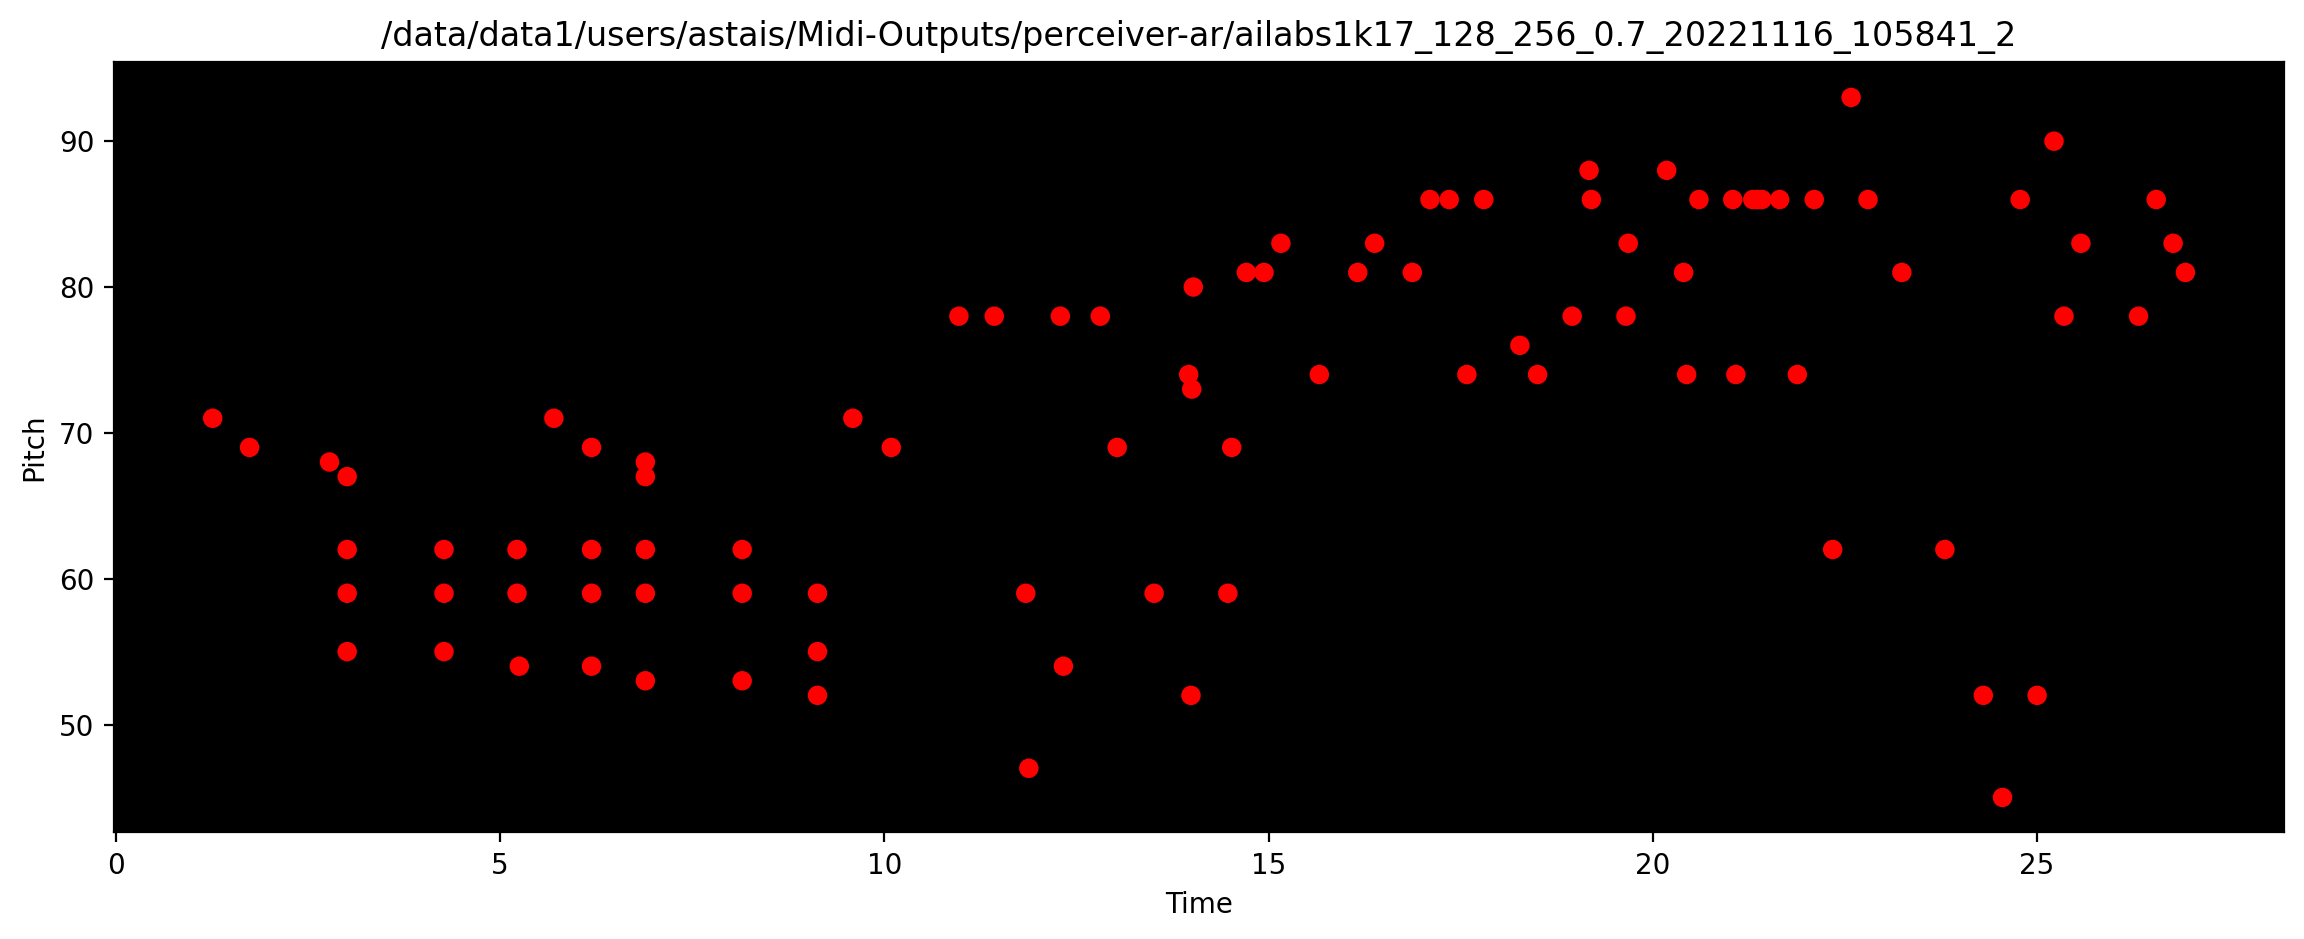

In [16]:
#@title Single Continuation Block Generator

#@markdown NOTE: Play with the settings to get different results
number_of_prime_tokens = 128 #@param {type:"slider", min:256, max:1020, step:4}
number_of_tokens_to_generate = 256 #@param {type:"slider", min:64, max:512, step:32}
temperature = 0.7 #@param {type:"slider", min:0.1, max:1, step:0.1}

#===================================================================
print('=' * 70)
print('Perceiver Music Model Continuation Generator')
print('=' * 70)
print('Generation settings:')
print('=' * 70)
print('Number of prime tokens:', number_of_prime_tokens)
print('Number of tokens to generate:', number_of_tokens_to_generate)
print('Model temperature:', temperature)

print('=' * 70)
print('Generating...')

# inp = augment(inputs)

# multiply the inputs by the ceiling of the division of 4096*4 by the length of the inputs
inp = inputs * math.ceil((4096 * 4) / len(inputs))

# take the first 4096*4 elements of the multiplied inputs
inp = inp[:(4096 * 4)]

# take the elements from 512+length of the prime tokens to the end of the multiplied inputs and add the prime tokens
inp = inp[(512+len(inputs[:number_of_prime_tokens])):] + inputs[:number_of_prime_tokens]

# convert the inputs to a long tensor and move it to the GPU
inp = torch.LongTensor(inp).cuda()

# generate the output using the model, the number of tokens to generate and the temperature
out = model.generate(inp[None, ...], 
                  number_of_tokens_to_generate, 
                  temperature=temperature)

# convert the output to a list
out1 = out.cpu().tolist()[0]

current_time = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# create the file name
file_name='/data/data1/users/astais/Midi-Outputs/perceiver-ar/'+dataset_name+'_'+str(number_of_prime_tokens)+"_"+str(number_of_tokens_to_generate)+'_'+str(temperature)+'_'+current_time+'_2'

# if the output is not empty
if len(out1) != 0:
 
 # output song
 song = inputs[:number_of_prime_tokens] + out1

song_f = []
time = 0
# set the duration to 0
dur = 0
# set the velocity to 0
vel = 0
# set the pitch to 0
pitch = 0
# set the channel to 0
channel = 0
son = []
song1 = []

# loop through the song
for s in song:
 
 # if the element is greater than 127
 if s > 127:
   son.append(s)
 
 # otherwise
 else:
   # if the list has 4 elements
   if len(son) == 4:
     song1.append(son)
   # reset the list
   son = []
   son.append(s)

# loop through the song1 list
for s in song1:
    
 # Piano
 channel = 0
 
 # multiply the first element of the list by 10 and add it to the time
 time += s[0] * 10
 
 # multiply the second element of the list by 20 and subtract 128
 dur = (s[1]-128) * 20
 
 # subtract 256 from the third element of the list
 pitch = (s[2]-256)
 
 # subtract 384 from the fourth element of the list
 vel = (s[3]-384)
 
 # if the pitch is not 0
 if pitch != 0:
   # add the note to the song_f list
   song_f.append(['note', time, dur, channel, pitch, vel ])

# convert the song_f list to a MIDI file
detailed_stats = TMIDIX.Tegridy_SONG_to_MIDI_Converter(song_f, 
                                                     output_signature = 'perceiver-ar',  
                                                     output_file_name = file_name, 
                                                     track_name='Degree Project - Angelos Stais',
                                                     list_of_MIDI_patches=[0, 24, 32, 40, 42, 46, 56, 71, 73, 0, 53, 19, 0, 0, 0, 0],
                                                     number_of_ticks_per_quarter=500)
print('Done!')
print('Displaying resulting composition...')
fname = file_name
x = []
y =[]
c = []
colors = ['red', 'yellow', 'green', 'cyan', 'blue', 'pink', 'orange', 'purple', 'gray', 'white', 'gold', 'silver']

for s in song_f:
  x.append(s[1] / 1000)
  y.append(s[4])
  c.append(colors[s[3]])

# FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))
# display(Audio(str(fname + '.wav'), rate=16000))
# fs = FluidSynth('/usr/share/soundfonts/FluidR3_GM.sf2') # arch
# fs.midi_to_audio(cadence_midi, 'cadence.wav')

plt.figure(figsize=(14,5))
ax=plt.axes(title=fname)
ax.set_facecolor('black')

plt.scatter(x,y, c=c)
plt.xlabel("Time")
plt.ylabel("Pitch")
plt.show()

Perceiver Music Model Auto-Continuation Generator
Generation settings:
Number of prime tokens: 128
Number of continuation notes: 128
Model temperature: 0.7
Generating...


  0%|          | 0/128 [00:00<?, ?it/s]

Converting to MIDI. Please stand-by...
Done! Enjoy! :)
Done!
Displaying resulting composition...


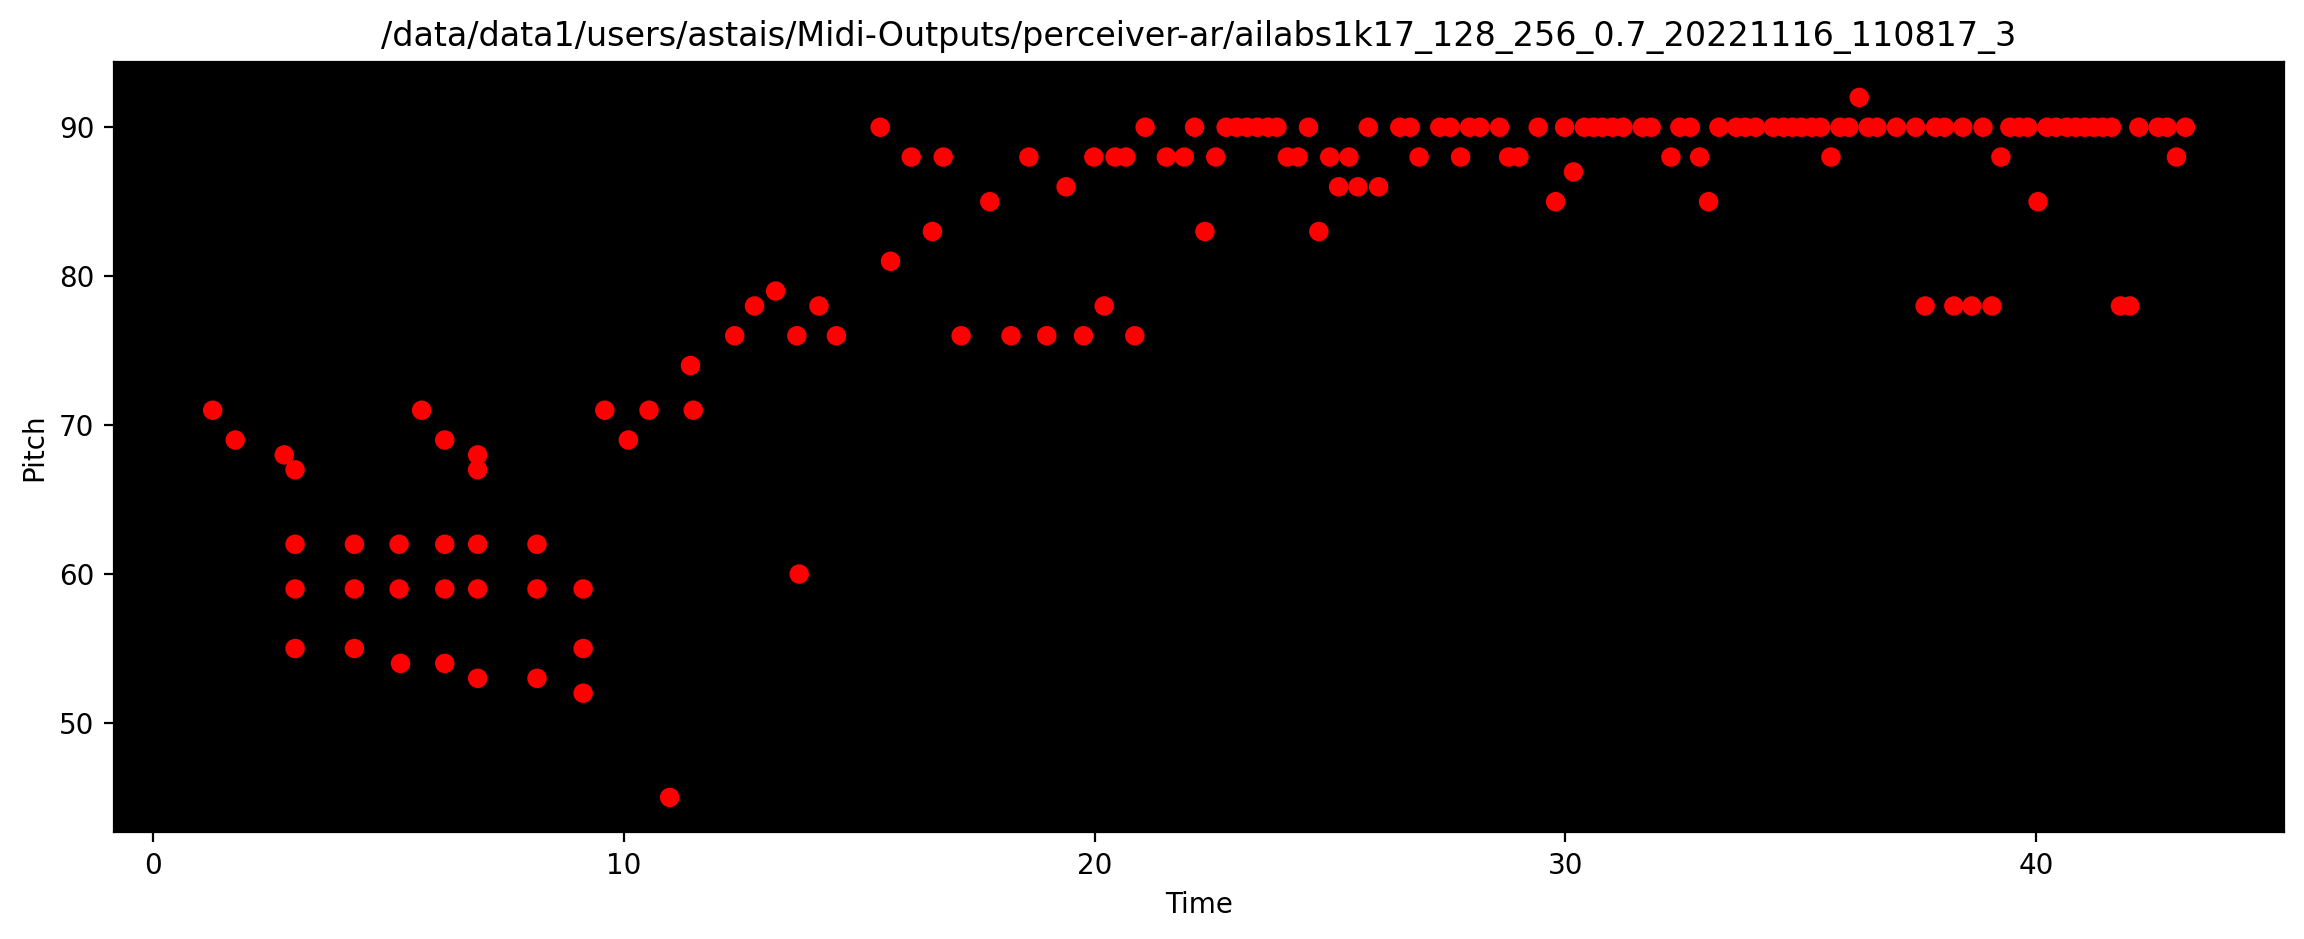

In [22]:
#@title Auto-Continue Custom MIDI
number_of_prime_tokens = 128 #@param {type:"slider", min:64, max:512, step:4}
number_of_continuation_notes = 128 #@param {type:"slider", min:10, max:500, step:10}
temperature = 0.7 #@param {type:"slider", min:0.1, max:1, step:0.1}

#===================================================================
print('=' * 70)
print('Perceiver Music Model Auto-Continuation Generator')
print('=' * 70)
print('Generation settings:')
print('=' * 70)
print('Number of prime tokens:', number_of_prime_tokens)
print('Number of continuation notes:', number_of_continuation_notes)
print('Model temperature:', temperature)
print('=' * 70)
print('Generating...')

out2 = copy.deepcopy(inputs[:number_of_prime_tokens])

current_time = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# Create a file name based on the dataset name, number of prime tokens, number of tokens to generate, temperature, and current time
file_name='/data/data1/users/astais/Midi-Outputs/perceiver-ar/'+dataset_name+'_'+str(number_of_prime_tokens)+"_"+str(number_of_tokens_to_generate)+'_'+str(temperature)+'_'+current_time+'_3'

# Loop through the number of continuation notes
for i in tqdm(range(number_of_continuation_notes)):

 # Create a copy of the inputs(primer midi) and truncate it to the length of 4096 * 4
 inp = inputs * math.ceil((4096 * 4) / len(inputs))
 inp = inp[:(4096 * 4)]
 
 # Add the output from the previous iteration to the truncated inputs
 inp = inp[(512+len(out2)):] + out2
 
 # Convert the inputs to a LongTensor and send it to the GPU
 inp1 = torch.LongTensor(inp).cuda()
 
 # Generate the output using the model
 out = model.generate(inp1[None, ...], 
                     4, 
                     temperature=temperature)               
 
 # Convert the output to a list
 out1 = out.cpu().tolist()[0]
 
 # Add the output to the output list
 out2.extend(out1)

# If the output list is not empty
if len(out2) != 0:
   
   # Create a song list
   song = out2
   
   # Initialize variables
   song_f = []
   time = 0
   dur = 0
   vel = 0
   pitch = 0
   channel = 0
   son = []
   song1 = []
   
   # Loop through the song list
   for s in song:
     # If the value is greater than 127, add it to the son list
     if s > 127:
       son.append(s)
     # Otherwise, if the son list has 4 elements, add it to the song1 list
     else:
       if len(son) == 4:
         song1.append(son)
       # Reset the son list
       son = []
       son.append(s)
   
   # Loop through the song1 list
   for s in song1:
       # Set the channel to 0 (Piano)
       channel = 0 
       # Increase the time by the first element of the list multiplied by 10
       time += s[0] * 10   
       # Set the duration to the second element of the list minus 128 multiplied by 20
       dur = (s[1]-128) * 20 
       # Set the pitch to the third element of the list minus 256
       pitch = (s[2]-256)
       # Set the velocity to the fourth element of the list minus 384
       vel = (s[3]-384)
       # If the pitch is not 0, add the note to the song_f list
       if pitch != 0:                          
         song_f.append(['note', time, dur, channel, pitch, vel ])
    detailed_stats = TMIDIX.Tegridy_SONG_to_MIDI_Converter(song_f,
                                                        output_signature = 'Perceiver',  
                                                        output_file_name = file_name, 
                                                        track_name='Project Los Angeles',
                                                        list_of_MIDI_patches=[0, 24, 32, 40, 42, 46, 56, 71, 73, 0, 53, 19, 0, 0, 0, 0],
                                                        number_of_ticks_per_quarter=500)
    print('Done!')

print('Displaying resulting composition...')
fname = file_name

x = []
y =[]
c = []
colors = ['red', 'yellow', 'green', 'cyan', 'blue', 'pink', 'orange', 'purple', 'gray', 'white', 'gold', 'silver']

for s in song_f:
  x.append(s[1] / 1000)
  y.append(s[4])
  c.append(colors[s[3]])

# FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))
# display(Audio(str(fname + '.wav'), rate=16000))
plt.figure(figsize=(14,5))
ax=plt.axes(title=fname)
ax.set_facecolor('black')
plt.scatter(x,y, c=c)
plt.xlabel("Time")
plt.ylabel("Pitch")
plt.show()

# Congrats! You did it! :)